In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
    num_paral_jobs = 8
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
    num_paral_jobs = 12
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.1.1
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Neuropixels data.

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

In [5]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

#### Fine Time Coupling Model

In [6]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)

#### Trials Selection

In [10]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261,
#                  278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261,
#                  286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989

In [7]:
condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  246 temp freq [15.0] orient [0.0] contrast [0.8] [ 3798  3852  3947  3966  3979 31016 31026 31160 31186 49206 49245 49346 49372 49409 49412]
1  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
2  256 temp freq [15.0] orient [270.0] contrast [0.8] [ 3811  3845  3942  3958 31003 31056 31112 31126 31137 31169 31191 49260 49305 49344 49381]
3  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
4  258 temp freq [4.0] orient [225.0] contrast [0.8] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
5  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
6  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275

## Spike Trains

In [8]:
trial_window = [0.4, 2.0]

# dt=0.002
# spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
# spike_trains = model.get_trial_metric_per_unit_per_trial(
#     stimulus_presentation_ids=all_trials_indices,
#     unit_ids=selected_units.index.values,
#     trial_time_window=trial_time_window,
#     metric_type='spike_trains', dt=dt)
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


In [9]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(261, 285)

# Trial-wise cluster, joint-trial filter fit.

In [10]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [11]:
select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3801  3810  3811  3813  3814  3816  3817  3819  3822  3824  3826  3828  3829  3831  3833  3835  3844
  3845  3848  3852  3855  3859  3860  3862  3866  3870  3872  3875  3876  3878  3880  3881  3882  3884  3886
  3888  3889  3895  3897  3898  3899  3900  3905  3906  3911  3912  3914  3917  3920  3921  3922  3924  3925
  3928  3930  3932  3933  3934  3936  3937  3938  3942  3943  3944  3946  3947  3948  3949  3951  3953  3955
  3956  3958  3959  3960  3962  3964  3966  3967  3968  3973  3979  3980  3981  3984  3986  3987  3988  3989
  3992  3995  3996  3997 31002 31003 31004 31014 31015 31016 31020 31021 31022 31024 31026 31027 31028 31033
 31034 31035 31039 31040 31043 31046 31047 31048 31051 31053 31054 31055 31056 31058 31062 31064 31066 31071
 31072 31075 31076 31078 31079 31080 31081 31085 31086 31089 31093 31096 31098 31104 31105 31112 31114 31116
 31125 31126 31129 31133 31135 31137 31142 31147 31148 31149 31151 31152 31154 31156 31159 31160 31161 31162
 31165 31166 31167 

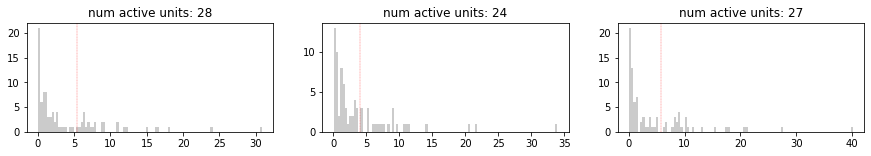

num_pairs: 672
num_pairs: 648


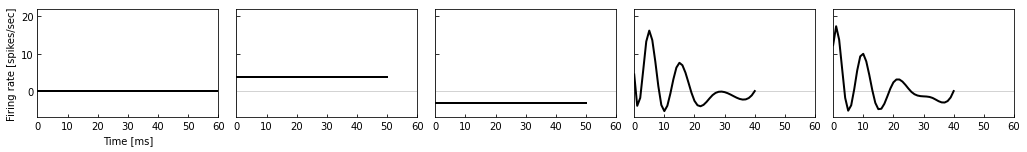

In [12]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr149_20210523-070711.pkl'
# filter_membership_CD = util.load_variable(file_path)
# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr149_20210523-070711.pkl'
# filter_membership_DE = util.load_variable(file_path)
# filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
# model.filter_membership_statistics(filter_membership_CD, verbose=True)
# model.filter_membership_statistics(filter_membership_DE, verbose=True)
# model.filter_membership_statistics(filter_membership_joint, verbose=True)
group_portion = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/group_model_pars_joint_itr29_20211113_102001.pkl'
group_model_pars = util.load_variable(file_path)
# group_model_pars[2]['beta'][2] = -2  # TMP manual modification.
model.plot_multiple_filters(group_model_pars, ylim=[-7, 22], num_rows_cols=[1,5])

### Parallel programming.

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  9.8min
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed: 15.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 10.6min
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed: 16.5min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 38221), (1.0, 40107), (2.0, 44100), (3.0, 37826), (4.0, 31266)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 28338), (1.0, 38490), (2.0, 45678), (3.0, 38330), (4.0, 33844)]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_11122021/filter_membership_CD_itr0_20211112-125631.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_11122021/filter_membership_DE_itr0_20211112-125631.pkl
Group portion: [0.20933189 0.19818417 0.20305645 0.19712047 0.19230702]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_11122021/group_portion_itr0_20211112-125631.pkl
filter_membership.shape (1320, 285)
#all trials:78597	#batch trials:78597
X.shape (1436031, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
 30%|██████████████████▉                     

D:/Brain_Network/Code\jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.482e-02
  print('gradient', gradient.reshape(-1))


#all trials:65110	#batch trials:65110
X.shape (1490255, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.80it/s]
num itr 59 [[-2510758.90802232]] 0.02213508015433481
beta [ 13.99089629   0.03841904  14.17711597  23.42511601 -22.46602916  21.40717463  -9.5842079    1.60312057
  -1.64284292   0.02701858  -4.31736917]
gradient [ -3.5592547  -51.47239448  -2.44581655  -2.69623007  -1.47793514  -3.05979079  -2.42272401  -1.69550297
  -1.5814418   -0.62389799   0.08065292]
Finish 4.


D:/Brain_Network/Code\jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.214e-02
  print('gradient', gradient.reshape(-1))


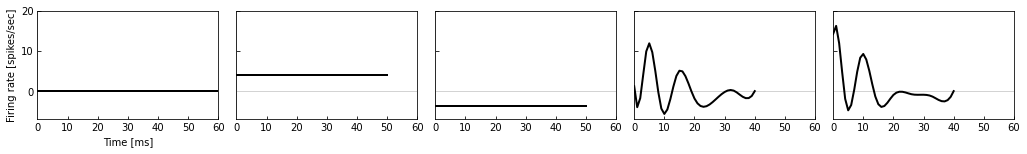

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_11122021/group_model_pars_joint_itr0_20211112-131651.pkl


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed: 15.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed: 17.1min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 48802), (1.0, 39407), (2.0, 48504), (3.0, 28977), (4.0, 25830)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 40010), (1.0, 36419), (2.0, 49544), (3.0, 30455), (4.0, 28252)]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_11122021/filter_membership_CD_itr1_20211112-134913.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_11122021/filter_membership_DE_itr1_20211112-134913.pkl
Group portion: [0.21902894 0.19697667 0.20666022 0.18983275 0.18750142]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_11122021/group_portion_itr1_20211112-134913.pkl
filter_membership.shape (1320, 285)
#all trials:75826	#batch trials:75826
X.shape (1333738, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
 28%|█████████████████▊                      

KeyboardInterrupt: 

In [33]:
output_dir = project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_randomempty_12182021_1151/'

for itr in range(0, 1):
    jobs_CD, jobs_DE = [], []
    for trial_id in selected_trial_ids:
        job1 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_CD, [trial_id], parallel=True)
        job2 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_DE, [trial_id], parallel=True)
        jobs_CD.append(job1)
        jobs_DE.append(job2)
    with Parallel(n_jobs=num_paral_jobs, verbose=1) as parallel_pool:
        jobs_CD_out = parallel_pool(jobs_CD)
        jobs_DE_out = parallel_pool(jobs_DE)
    filter_membership_CD = pd.concat(jobs_CD_out, axis=1)
    filter_membership_DE = pd.concat(jobs_DE_out, axis=1)
    model.filter_membership_statistics(filter_membership_CD)
    model.filter_membership_statistics(filter_membership_DE)
    file_path = output_dir + f'filter_membership_CD_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_CD)
    file_path = output_dir + f'filter_membership_DE_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_DE)

#     filter_membership_joint = filter_membership_CD.append(filter_membership_DE)

#     group_portion = model.update_membership_portion(5, filter_membership_joint)
#     file_path = output_dir + f'group_portion_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
#     util.save_variable(file_path, group_portion)

#     group_model_pars = model.update_cluster_filter_joint_trail(filter_membership_joint, verbose=True)
#     model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5])
#     file_path = output_dir + f'group_model_pars_joint_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
#     util.save_variable(file_path, group_model_pars)